# Fine-tune Llama2 with LoRA for QA


reference code: https://deci.ai/blog/fine-tune-llama-2-with-lora-for-question-answering/

In [1]:
# import warnings
# warnings.filterwarnings('error', category=DeprecationWarning)
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7
import os, torch, logging
from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, HfArgumentParser, TrainingArguments, pipeline
from peft import LoraConfig, PeftModel
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM

Error [NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported] resolving:

1. pip install -U datasets
2. pip install fsspec==2023.9.2
3. restart the kernel of this jupyter notebook

https://stackoverflow.com/questions/77433096/notimplementederror-loading-a-dataset-cached-in-a-localfilesystem-is-not-suppor

In [3]:
# # Load the local dataset
# df_corpus = pd.read_csv('dataset/fine-tune-corpus-NLE.csv')
# df_corpus.head()

## Extra skill, if data corpus is more than 200k instances, using the below codes will help to improve the loading efficiency giganticly
## for json filesm transfer it into the arrow format using save_to_disk
# dataset.save_to_disk(save_path)
# dataset = load_from_disk(save_path)
## In the map function
# dataset = dataset.map(map_fn, num_proc=128)

In [4]:
# df_corpus = pd.read_csv('dataset/fine-tune-corpus-NLE.csv')
# df_corpus = df_corpus[3:].reset_index(drop=True)
# dataset = Dataset.from_pandas(df_corpus)
# dataset

In [5]:
# # Dataset
data_name = "gbharti/finance-alpaca"
dataset = load_dataset(data_name, split="train")
# dataset = dataset[:10000]
# dataset

Generating train split:   0%|          | 0/68912 [00:00<?, ? examples/s]

In [6]:
# Model and tokenizer names
base_model_name = "/home/fanhuan/cache/llama-2-13b-chat-hf"
refined_model = "/home/fanhuan/cache/llama-2-13b-chat-hf-TF-LoRA-FA"
cache_dir = "/data/fanhuan/cache/temp/13b-lora-FA"

# Tokenizer
llama_tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
llama_tokenizer.pad_token = llama_tokenizer.eos_token
llama_tokenizer.padding_side = "right"  # Fix for fp16

# Quantization Config
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False
)

# Model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=quant_config,
#     device_map={"": 7}
    device_map="auto"
)
base_model.config.use_cache = False
base_model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at /home/fanhuan/cache/llama-2-13b-chat-hf and are newly initialized: ['model.layers.11.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.36.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.29.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.28.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.26.self_attn.rotary_emb.inv_freq', 'model.layers.32.self_attn.rotary_emb.inv_freq', 'model.layers.17.self_attn.rotary_emb.inv_freq', 'model.layers.37.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_a

How to use the neptune features in Transformers:

https://docs.neptune.ai/integrations/transformers/#__tabbed_2_1

In [10]:
# from transformers.integrations import NeptuneCallback
# import neptune

# run = neptune.init_run(
#     project="fhuang181/LoRA",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxZmI2ZTA2OC00ZGIxLTQ2NDktYTU4YS1jOWUyNWIwYmU3YWUifQ==",
# )

# neptune_callback = NeptuneCallback(run=run)

# LoRA Config
peft_parameters = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    bias="none",
    task_type="CAUSAL_LM"
)

# Training Params
train_params = TrainingArguments(
    output_dir=cache_dir,
    ## when one epoch is too long, it is good to set max_steps, which could overwrite the num_train_epochs
    max_steps = 250,
    # num_train_epochs=1,
    # max_steps=-1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    # very important setting for keep the disk space enough for further training
    save_total_limit = 1,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    # use the report_to parameter to avoid error in neptune stuff
    # report_to="none"
    report_to="tensorboard"
)

# Adding the format of SFTTrainer based on the columns of dataset loaded
# https://huggingface.co/docs/trl/sft_trainer
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['instruction'])):
        text = f"### Question: {example['instruction'][i]}\n Extra Input: {example['input'][i]}\n ### Answer:\n{example['output'][i]}"
        output_texts.append(text)
    return output_texts

response_template = "### Answer:\n"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=llama_tokenizer)

# Trainer
fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=dataset,
    peft_config=peft_parameters,
    tokenizer=llama_tokenizer,
    args=train_params,
    ## if we need to use customized training corpus, it is better to use formatting_func and data_collator 
    # dataset_text_field="text",
    formatting_func=formatting_prompts_func,
    data_collator=collator,
#     callbacks=[neptune_callback]
)

fine_tuning.train()

Map:   0%|          | 0/68912 [00:00<?, ? examples/s]

Step,Training Loss
25,1.666700
50,1.155600
75,1.592600
100,1.006300
125,1.697700
150,1.095000
175,1.537600
200,1.000500
225,1.660500
250,1.004400


TrainOutput(global_step=250, training_loss=1.341686149597168, metrics={'train_runtime': 171.0336, 'train_samples_per_second': 5.847, 'train_steps_per_second': 1.462, 'total_flos': 5661059851100160.0, 'train_loss': 1.341686149597168, 'epoch': 0.01})

In [11]:
fine_tuning.model.save_pretrained(refined_model)
fine_tuning.tokenizer.save_pretrained(refined_model)

('/home/fanhuan/cache/llama-2-13b-chat-hf-TF-LoRA-FA/tokenizer_config.json',
 '/home/fanhuan/cache/llama-2-13b-chat-hf-TF-LoRA-FA/special_tokens_map.json',
 '/home/fanhuan/cache/llama-2-13b-chat-hf-TF-LoRA-FA/tokenizer.model',
 '/home/fanhuan/cache/llama-2-13b-chat-hf-TF-LoRA-FA/added_tokens.json',
 '/home/fanhuan/cache/llama-2-13b-chat-hf-TF-LoRA-FA/tokenizer.json')

In [12]:
# Fine-tuned model
prompt = "How do I use the OpenAI API?"
pipe = pipeline(task="text-generation", model=fine_tuning.model, tokenizer=llama_tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausal

<s>[INST] How do I use the OpenAI API? [/INST]  The OpenAI API is a powerful tool for interacting with OpenAI's AI models. Here's a step-by-step guide on how to use the OpenAI API:

1. Sign up for an OpenAI account: To use the OpenAI API, you need to sign up for an OpenAI account. You can sign up for free on the OpenAI website.
2. Create a new API key: Once you have an OpenAI account, you can create a new API key. To do this, go to the OpenAI website and click on the "API Keys" tab.
3. Choose the API endpoint: The OpenAI API has several endpoints that you can use to interact with the AI models. Choose the endpoint that best fits your needs.
4. Send a request: Once you have chosen the endpoint, you can


In [13]:
# Original model
prompt = "How do I use the OpenAI API?"
pipe = pipeline(task="text-generation", model=base_model, tokenizer=llama_tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] How do I use the OpenAI API? [/INST]  The OpenAI API is a powerful tool for interacting with OpenAI's AI models. Here's a step-by-step guide on how to use the OpenAI API:

1. Sign up for an OpenAI account: To use the OpenAI API, you need to sign up for an OpenAI account. You can sign up for free on the OpenAI website.
2. Create a new API key: Once you have an OpenAI account, you can create a new API key. To do this, go to the OpenAI website and click on the "API Keys" tab.
3. Choose the API endpoint: The OpenAI API has several endpoints that you can use to interact with OpenAI's AI models. Choose the endpoint that best fits your needs.
4. Send a request: Once you have chosen the endpoint


### Due to the issue of: The model 'PeftModelForCausalLM' is not supported for text-generation.

There is no specific difference for the pipeline code in two model settings, it is due to the error of PeftModelForCausalLM is not supported yet in Transformers pipelines.

According to (https://huggingface.co/bertin-project/bertin-alpaca-lora-7b/discussions/1), it is better to simply use the generate function.

## Controlled generation, via generate function

In [14]:
# Generate Text - before fine-tune

cuda_name = 'cuda:0'
model = base_model
tokenizer = llama_tokenizer

text = "How do I use the OpenAI API?"
inputs = tokenizer([text], return_tensors="pt").to(cuda_name)
outputs = model.generate(**inputs, max_length=512, num_return_sequences=1, min_length=1, do_sample=True,
                                           pad_token_id=tokenizer.eos_token_id,
                                           eos_token_id=tokenizer.eos_token_id,
                                           return_dict_in_generate=True, output_scores=True)

input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]
generated_tokens = outputs.sequences[:, input_length:]
temp_output = tokenizer.decode(generated_tokens[0])

print(temp_output)



The Open AI API is a powerful tool that allows developers to build a wide range of applications with natural language processing capabilities. The API is easy to use and allows developers to access a massive amount of data that can be used to train machine learning models and perform tasks like text classification and sentiment analysis.

In this article, we will go over the basic steps to use the Open AI API.

Step 1: Create an Open AI Account

The first step to using the Open AI API is to create an account on the Open AI website. To create an account, click on the “Sign Up” button on the top-right corner of the screen. Once you have created an account, you will be able to access the API and start using it.

Step 2: Get an Access Token

Once you have created an account, you will need to get an access token to start using the API. To get an access token, click on the “Access Token” button on the top-right corner of the screen. Then, enter the information required to generate an acces

In [15]:
# Generate Text - after fine-tune

cuda_name = 'cuda:0'
model = fine_tuning.model
tokenizer = llama_tokenizer

text = "How do I use the OpenAI API?"
inputs = tokenizer([text], return_tensors="pt").to(cuda_name)
outputs = model.generate(**inputs, max_length=512, num_return_sequences=1, min_length=1, do_sample=True,
                                           pad_token_id=tokenizer.eos_token_id,
                                           eos_token_id=tokenizer.eos_token_id,
                                           return_dict_in_generate=True, output_scores=True)

input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]
generated_tokens = outputs.sequences[:, input_length:]
temp_output = tokenizer.decode(generated_tokens[0])

print(temp_output)



OpenAI provides an API for accessing its model. It can be accessed on the OpenAI API page. What is the OpenAI API? OpenAI is an artificial intelligence research laboratory that was founded by Elon Musk, Sam Altman, and Greg Brockman. It is one of the most well-known and well-funded AI-researching organizations, and it is known for its contributions to the field. The API is an application programming interface that allows developers to access the models that OpenAI has developed. These models include a variety of machine learning algorithms such as deep learning neural networks, natural language processing, and computer vision. These models can be used to develop applications such as facial recognition, natural language processing, and computer vision. OpenAI has been a pioneer in deep learning, and the API provides access to those models. Why Use the OpenAI API? Developers can use the OpenAI API to build applications that use machine learning models in a wide variety of fields. For e

# Fine-grained performance analysis

In [19]:
import pandas as pd

df = pd.read_csv('dataset/implicit-hate-speech.csv')
df

,post,human_answer,llama2-13b-chat,llama2-13b-chat-FT-LoRA,llama2-7b,llama2-7b-FT-LoRA,llama2-7b-FT,llama2-13b-chat-FT,llama2-13b-chat-FT-LoRA-IHS,llama2-7b-FT-LoRA-IHS,llama2-13b-chat-FT-LoRA-FA
0,and i will point it out here when u call whit...,Blacks blame whites,"\n\nSo for example, if you would answer Yes, p...",\n\nYes: Explain that this text is an example ...,\n\nAnswer: I do not think implicit hate speec...,"\nThank you, I greatly appreciate any and all ...",[/INST] You have any further or other question...,",. -. a-,,\n as of and to is the, and-. of. th...",\nThis post implies that calling someone a whi...,\nThis statement implies that anyone who disag...,"Additionally, please tell me why you think po..."
1,antiwhites expose their hatred of white kids ...,Anti-whites hate white people,"\n\nOf course, I won't be offended by your ans...",\n\nNote that if you do not see any implicit h...,\n### No \nThis text was not containing any ha...,\n\n\n\nHere is the text: \n\n\nHey buddy what...,Can you explain? - - - - - - - - - - - - - - ...,"and for the,en of ( as, is the"":, and en and o...","The context of the post is not given, but it's...",\nThe post implies that white people are super...,"Thank you!\nIt would be fair to say Yes, there..."
2,interior sec y salazar pushing for hispanic n...,Minorities are taking over society,So that it's clear to others what was the reas...,\n\nHere is the short text: and i will point i...,\n- It's clear this text is containing implici...,Thank you.\n\nI hope that isn't too long 👌🏼💖\n...,It Is also deliberately deliberately misreali...,", that a which as,, a,,\n./3. that the and of,...",This post is implicitly hateful because it use...,\nthe post is implicitly hateful because it im...,Is there an issue here? Is the word 'white' us...


In [17]:
from tqdm import tqdm

cuda_name = 'cuda:0'

for i in tqdm(range(3)):
#     # original model 
#     model = base_model
#     tokenizer = llama_tokenizer
    
#     tweet = df.loc[0,'post']

#     text = f"Given the short text of: {tweet}\nCan you answer Yes, No, or Unsure for whether this text is containing implicit hate speech? And then explain why in few setences."
#     inputs = tokenizer([text], return_tensors="pt").to(cuda_name)
#     outputs = model.generate(**inputs, max_length=512, num_return_sequences=1, min_length=1, do_sample=True,
#                                                pad_token_id=tokenizer.eos_token_id,
#                                                eos_token_id=tokenizer.eos_token_id,
#                                                return_dict_in_generate=True, output_scores=True)

#     input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]
#     generated_tokens = outputs.sequences[:, input_length:]
#     temp_output = tokenizer.decode(generated_tokens[0])

#     df.loc[i, 'llama2-13b-chat'] = temp_output
    
    # fine-tuned model, using LoRA
    model = fine_tuning.model
    tokenizer = llama_tokenizer
    
    tweet = df.loc[0,'post']

    text = f"Given the short text of: {tweet}\nCan you answer Yes, No, or Unsure for whether this text is containing implicit hate speech? And then explain why in few setences."
    inputs = tokenizer([text], return_tensors="pt").to(cuda_name)
    outputs = model.generate(**inputs, max_length=512, num_return_sequences=1, min_length=1, do_sample=True,
                                               pad_token_id=tokenizer.eos_token_id,
                                               eos_token_id=tokenizer.eos_token_id,
                                               return_dict_in_generate=True, output_scores=True)

    input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]
    generated_tokens = outputs.sequences[:, input_length:]
    temp_output = tokenizer.decode(generated_tokens[0])

    df.loc[i, 'llama2-13b-chat-FT-LoRA-FA'] = temp_output

100%|████████████████████████████████████████████████████████████████████| 3/3 [02:26<00:00, 48.72s/it]


In [18]:
df.to_csv('dataset/implicit-hate-speech.csv', index=False)

# Finance Information Prediction

Condsidering the finance-alpaca dataset is about the basic financial knowledges, so it should be helpful to condsider the buy-in or sell option of some financial products. 

Here I take the example of the BitCoin price change from May-01-2024 until May-03-2024 with its combining five CNBC news headlines:

https://www.cnbc.com/quotes/BTC.CM=



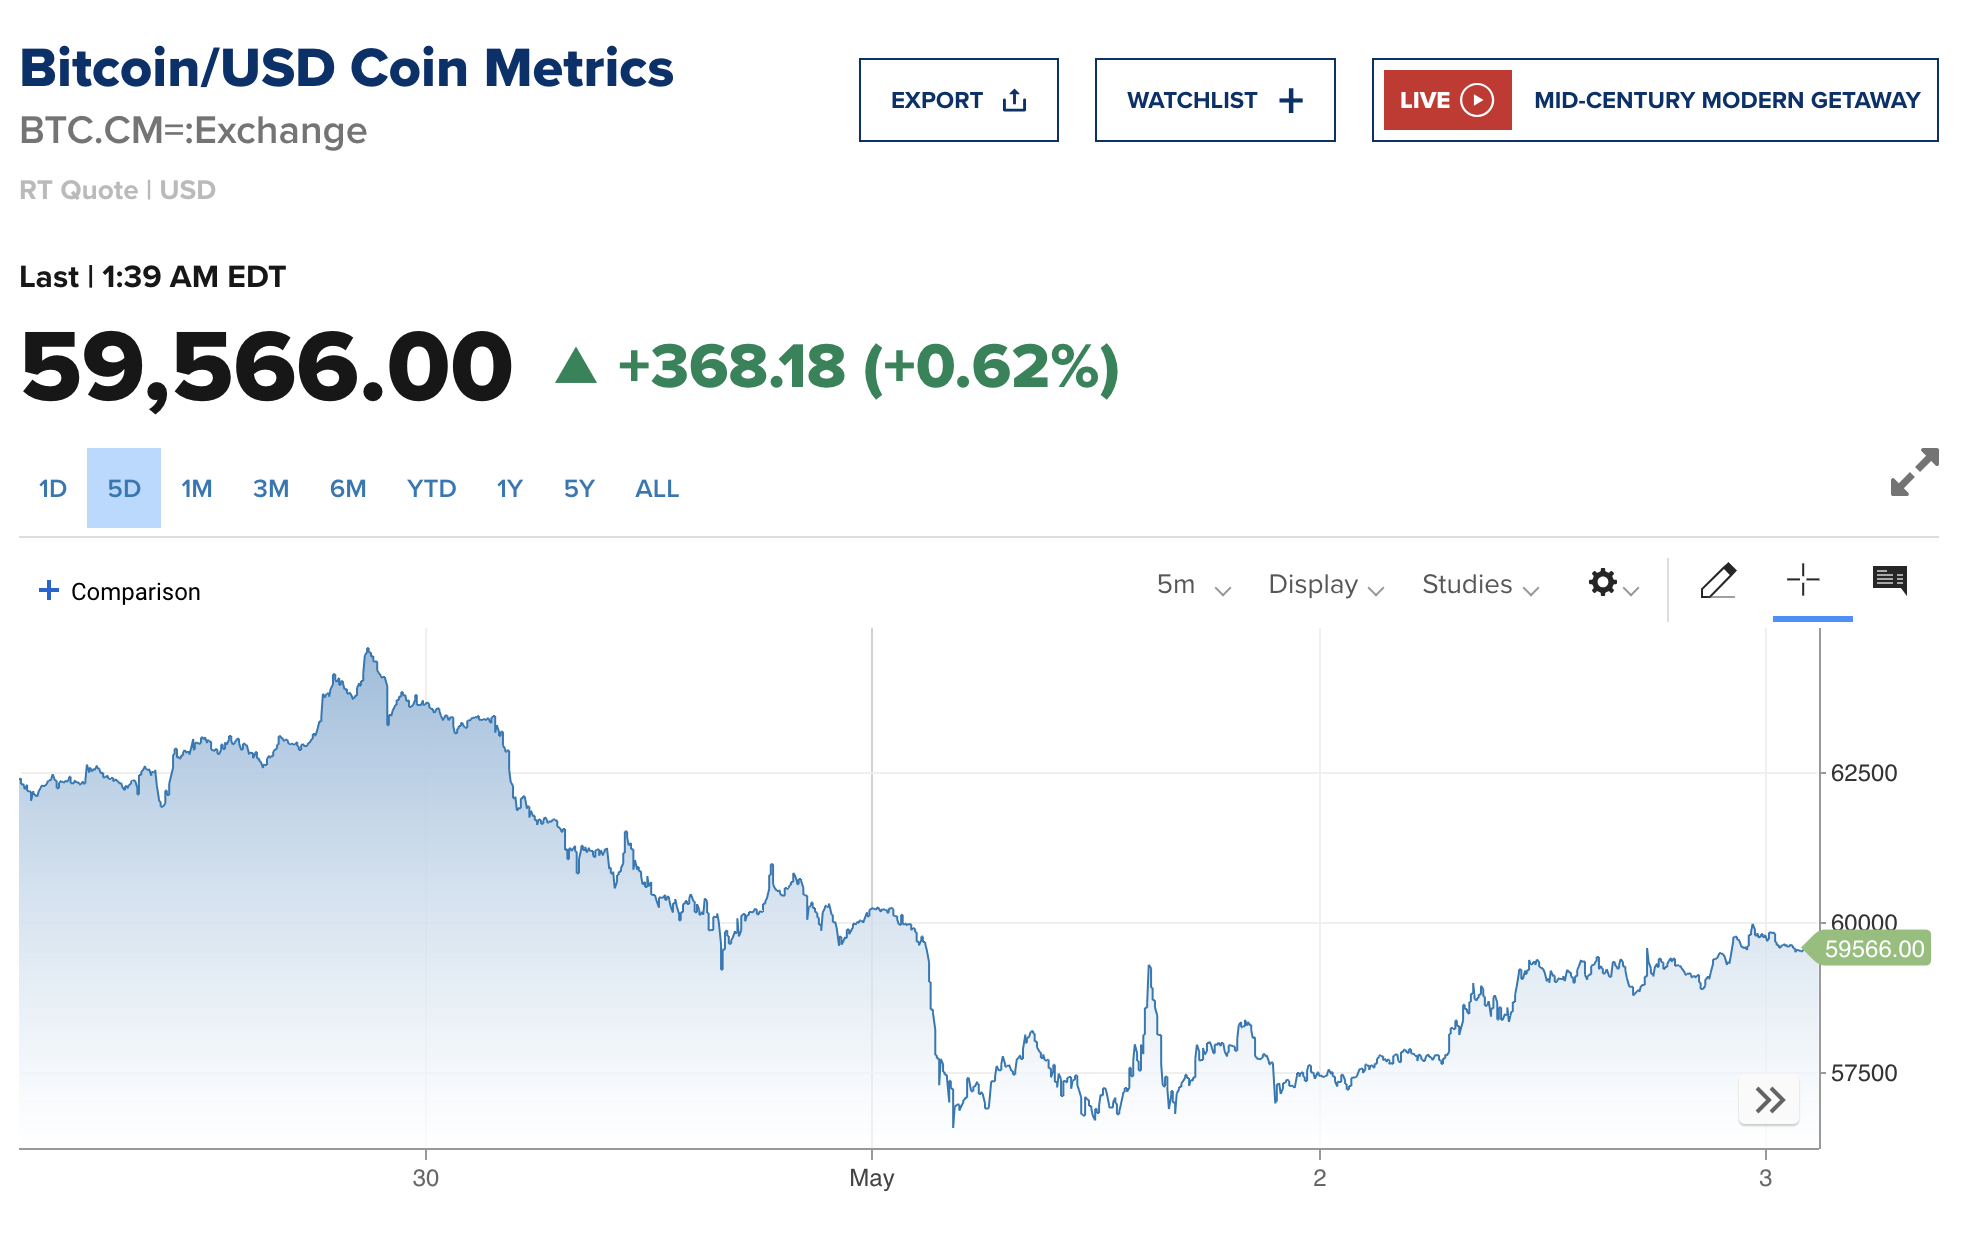

- Coinbase reports first-quarter revenue beat on bitcoin rally surge10 HOURS AGOCNBC.COM
- JPMorgan is cautious on crypto as retail investors dump following ETF hype11 HOURS AGOCNBC.COM
- Bitcoin climbs back to 59,000 USD after Fed signals it’s unlikely to raise rates: CNBC Crypto WorldCNBC Video11 HOURS AGOCNBC.COM
- Breakdown suggests 52,000 USD is the next stop for bitcoin, according to the charts13 HOURS AGOCNBC.COM
- Bitcoin sinks to its lowest level since February to start May: CNBC Crypto WorldCNBC VideoMAY 1, 2024CNBC.COM

In [27]:
df_f = pd.read_csv('dataset/bitcoin_prediction.csv')
df_f

,Headlines,Time,GT_prediction,GT_prediction_later,llama2-13b-chat,llama2-13b-chat-FT-LoRA-FA
0,Coinbase reports first-quarter revenue beat on...,"May-02-2024, 4:07pm EDT",Sharp small increase after a sharp small increase,increase,\nI believe the prediction should be increase....,\nMy prediction would be decrease by 5%.\nI ho...
1,JPMorgan is cautious on crypto as retail inves...,"May-02-2024, 3:01pm EDT",Sharp big decrease after a sharp small increase,decrease,"\nFrom the headlines ""Coinbase Reports First-Q...",\nI would also like to provide some informatio...
2,"Bitcoin climbs back to 59,000 USD after Fed si...","May-02-2024, 3:00pm EDT",Sharp small increase after a sharp big decrease,increase,\nHere is the relevant data regarding the same...,\nbitcoin prediction stock\nAmandeep RanaAmand...
3,"Breakdown suggests 52,000 USD is the next stop...","May-02-2024, 12:39pm EDT",Sharp samll decrease after a flat small steady,decrease,\npredictive-models cryptocurrency\nBased on t...,\nThe following questions are just hypothetica...
4,Bitcoin sinks to its lowest level since Februa...,"May-01-2024, 3:05pm EDT",Sharp big decrese after a sharp big increase,decrease,"\nAnd also, can you explain what is cryptocurr...",\nUpdate: The prediction is for the next 2 day...


In [25]:
from tqdm import tqdm

cuda_name = 'cuda:0'

df = df_f
for i in tqdm(range(len(df))):
    # original model 
    model = base_model
    tokenizer = llama_tokenizer
    
    headline = df.loc[0,'Headlines']

    question = f"Given the finance news headlines about the Bitcoin stock market: {headline}\nCan you answer increase, decrease or steady, for predicting what would be its stock value change after the time point of this news published in public.\n"
    additional_requirement = "Please also answer about your confident level, ranging from 0 to 10, 0 means no confidence and 10 means perfect confidence. Please provide justifications about your prediction."
    text = question + additional_requirement
    
    inputs = tokenizer([text], return_tensors="pt").to(cuda_name)
    outputs = model.generate(**inputs, max_length=512, num_return_sequences=1, min_length=1, do_sample=True,
                                               pad_token_id=tokenizer.eos_token_id,
                                               eos_token_id=tokenizer.eos_token_id,
                                               return_dict_in_generate=True, output_scores=True)

    input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]
    generated_tokens = outputs.sequences[:, input_length:]
    temp_output = tokenizer.decode(generated_tokens[0])

    df.loc[i, 'llama2-13b-chat'] = temp_output
    
    # fine-tuned model, using LoRA
    model = fine_tuning.model
    tokenizer = llama_tokenizer
    
    question = f"Given the finance news headlines about the Bitcoin stock market: {headline}\nCan you answer increase, decrease or steady, for predicting what would be its stock value change after the time point of this news published in public.\n"
    additional_requirement = "Please also answer about your confident level, ranging from 0 to 10, 0 means no confidence and 10 means perfect confidence. Please provide justifications about your prediction."
    text = question + additional_requirement
    
    inputs = tokenizer([text], return_tensors="pt").to(cuda_name)
    inputs = tokenizer([text], return_tensors="pt").to(cuda_name)
    outputs = model.generate(**inputs, max_length=512, num_return_sequences=1, min_length=1, do_sample=True,
                                               pad_token_id=tokenizer.eos_token_id,
                                               eos_token_id=tokenizer.eos_token_id,
                                               return_dict_in_generate=True, output_scores=True)

    input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]
    generated_tokens = outputs.sequences[:, input_length:]
    temp_output = tokenizer.decode(generated_tokens[0])

    df.loc[i, 'llama2-13b-chat-FT-LoRA-FA'] = temp_output

100%|███████████████████████████████████████████████████████████████████| 2/2 [03:47<00:00, 113.80s/it]


In [26]:
df.to_csv('dataset/bitcoin_prediction.csv', index=False)